In [2]:
# Import necessary libraries
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerImageProcessor
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, AutoProcessor
from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np
import requests
import pandas as pd

In [3]:
# Load the models and processors

# 0. places365 model
places_model = models.resnet18(num_classes=365)
checkpoint = torch.utils.model_zoo.load_url('http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar', map_location=torch.device('cpu'))
state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
places_model.load_state_dict(state_dict)
places_model.eval()

# 1. Finetuned SegFormer for sidewalks - https://huggingface.co/nickmuchi/segformer-b4-finetuned-segments-sidewalk
segmentation_model = SegformerForSemanticSegmentation.from_pretrained("nickmuchi/segformer-b4-finetuned-segments-sidewalk")
segmentation_processor = SegformerImageProcessor.from_pretrained("nickmuchi/segformer-b4-finetuned-segments-sidewalk")

# 2. Road condition classification - https://huggingface.co/chuuuuuuee/road_condition
classification_model = AutoModelForImageClassification.from_pretrained("chuuuuuuee/road_condition")
classification_processor = AutoProcessor.from_pretrained("chuuuuuuee/road_condition")

# 3. Fine-tuned  object detection for road traffic - https://huggingface.co/josephlyr/detr-resnet-50_finetuned_road_traffic
detection_model = DetrForObjectDetection.from_pretrained("josephlyr/detr-resnet-50_finetuned_road_traffic")
detection_processor = DetrImageProcessor.from_pretrained("josephlyr/detr-resnet-50_finetuned_road_traffic")

# 4. General object detection (ResNet50) - https://huggingface.co/facebook/detr-resnet-50
general_detection_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
general_detection_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS ex

Note: I decided to use nickmuchi's segmentation model referenced above as opposed to iammartian0's: https://huggingface.co/iammartian0/RoadSense_High_Definition_Street_Segmentation. Both models got their data from the `semantic-sidewalk` dataset (https://huggingface.co/datasets/segments/sidewalk-semantic) but the former uses the b4-sized SegFormer as opposed to the latter's dependence on the b0-sized SegFormer. The b4-sized SegFormer uses a larger volume of data and generally performs better. 

# Prerequisites

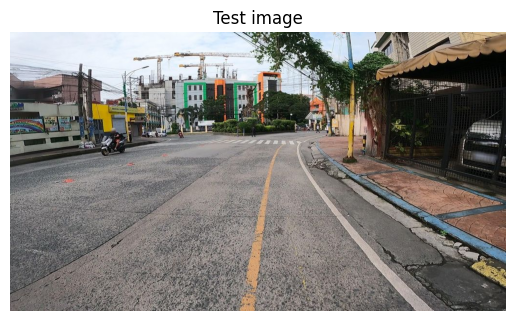

In [36]:
# Test image
image_path = "downloaded_images/6662508673859174_14.578278437308_121.03496566218.jpg"
original_image = Image.open(image_path).convert("RGB")
plt.imshow(original_image)
plt.axis('off')
plt.title('Test image')
plt.show()

In [37]:
file_path = 'sidewalk_semantic_categories.txt'
sidewalk_semantic_categories = {}

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        key = int(parts[0])
        value = parts[1]
        sidewalk_semantic_categories[key] = value

sidewalk_semantic_categories

{0: 'unlabeled',
 1: 'flat-road',
 2: 'flat-sidewalk',
 3: 'flat-crosswalk',
 4: 'flat-cyclinglane',
 5: 'flat-parkingdriveway',
 6: 'flat-railtrack',
 7: 'flat-curb',
 8: 'human-person',
 9: 'human-rider',
 10: 'vehicle-car',
 11: 'vehicle-truck',
 12: 'vehicle-bus',
 13: 'vehicle-tramtrain',
 14: 'vehicle-motorcycle',
 15: 'vehicle-bicycle',
 16: 'vehicle-caravan',
 17: 'vehicle-cartrailer',
 18: 'construction-building',
 19: 'construction-door',
 20: 'construction-wall',
 21: 'construction-fenceguardrail',
 22: 'construction-bridge',
 23: 'construction-tunnel',
 24: 'construction-stairs',
 25: 'object-pole',
 26: 'object-trafficsign',
 27: 'object-trafficlight',
 28: 'nature-vegetation',
 29: 'nature-terrain',
 30: 'sky',
 31: 'void-ground',
 32: 'void-dynamic',
 33: 'void-static',
 34: 'void-unclear'}

# Step 1: Scene Classification using Places365

In [6]:
# Load Places365 scene categories - https://github.com/CSAILVision/places365/blob/master/categories_places365.txt
with open('categories_places365.txt') as f: 
    categories = [line.strip().split(' ')[0][3:] for line in f]

def preprocess_image_for_places365(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image)
    return input_tensor.unsqueeze(0)  # Create a mini-batch of size 1

def is_road_image(image_path, model, categories=categories):
    input_batch = preprocess_image_for_places365(image_path)
    with torch.no_grad():
        outputs = model(input_batch)
    _, predicted = outputs.max(1)
    predicted_label = categories[predicted]
    road_related_categories = ['road', 'street', 'highway', 'alley', 'bridge', 'crosswalk', 'driveway', 'field_road', 'forest_path', 'forest_road', 'mountain_path', 'mountain_road', 'railroad_track', 'residential_neighborhood']
    return predicted_label in road_related_categories, predicted_label

In [7]:
is_road, scene_label = is_road_image(image_path, places_model, categories)
if not is_road:
    print(f"Image filtered out. Detected scene category: {scene_label}")
else:
    print(f"Image confirmed as road-related. Detected scene category: {scene_label}")

Image confirmed as road-related. Detected scene category: street


# Step 2: Segmentation using SegFormer for sidewalks

In [8]:
def segment_image(image_path, feature_extractor, segformer_model):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = segformer_model(**inputs)
    logits = outputs.logits  # (batch_size, num_classes, height, width)
    predicted_class = logits.argmax(dim=1).squeeze(0).cpu().numpy()
    return predicted_class

def visualize_segmentation(predicted_class):
    plt.imshow(predicted_class, cmap="jet")
    plt.title("Segmented Image via SegFormer for sidewalks")
    plt.axis('off')
    plt.show()

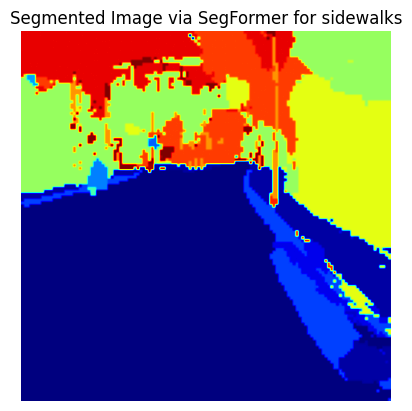

In [9]:
image_segmentation = segment_image(image_path, segmentation_processor, segmentation_model)
visualize_segmentation(image_segmentation)

In [10]:
categories_present = np.unique(image_segmentation).tolist()
category_labels_present = [sidewalk_semantic_categories[c] for c in categories_present]
print(category_labels_present)

['flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane', 'flat-parkingdriveway', 'flat-curb', 'human-person', 'human-rider', 'vehicle-car', 'vehicle-bicycle', 'construction-building', 'construction-wall', 'construction-fenceguardrail', 'object-pole', 'object-trafficsign', 'nature-vegetation', 'nature-terrain', 'sky', 'void-ground', 'void-dynamic', 'void-static']


# (Skipped) Step 3: Estimate Obstruction Density

In [11]:
def calculate_obstruction_density(segmentation):
    obstruction_categories = {
        8, 9, 10, 11, 12, 13, 14, 15, 16, 17,  # Humans and Vehicles
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27  # Construction and Objects
    }
    obstruction_pixels = np.isin(segmentation, list(obstruction_categories)).sum()
    total_pixels = segmentation.size

    obstruction_density = obstruction_pixels / total_pixels
    return obstruction_density

In [12]:
calculate_obstruction_density(image_segmentation)

0.28179931640625

# (Skipped) Step 4: Estimate Other Metrics

In [13]:
def calculate_metrics(segmentation_mask, category_mapping=sidewalk_semantic_categories):

    areas = {category_mapping[i]: np.sum(segmentation_mask == i) for i in range(len(category_mapping))}
    total_area = segmentation_mask.size

    metrics = {
        'sidewalk_coverage_ratio': (
            areas['flat-sidewalk'] /
            (areas['flat-road'] + areas['flat-sidewalk'] + areas['flat-crosswalk'])
            if (areas['flat-road'] + areas['flat-sidewalk'] + areas['flat-crosswalk']) > 0
            else 0
        ),
        'protected_lane_ratio': (
            areas['flat-cyclinglane'] /
            areas['flat-road']
            if areas['flat-road'] > 0
            else 0
        ),
        'greenery_ratio': (
            (areas['nature-vegetation'] + areas['nature-terrain']) /
            total_area
        # ),
        # 'pedestrian_vehicle_interaction_score': (
        #     (areas['flat-crosswalk'] + areas['flat-sidewalk']) /
        #     (areas['flat-road'] + vehicle_count)
        #     if (areas['flat-road'] + vehicle_count) > 0
        #     else 0
        # ),
        # 'safety_infrastructure_ratio': (
        #     (areas['flat-curb'] + obstruction_count) /
        #     (areas['flat-road'] + areas['flat-sidewalk'])
        #     if (areas['flat-road'] + areas['flat-sidewalk']) > 0
        #     else 0
        # ),
        # 'vehicle_dominance_index': (
        #     vehicle_count / areas['flat-road']
        #     if areas['flat-road'] > 0
        #     else 0
        # ),
        # 'pedestrian_comfort_index': (
        #     (areas['flat-sidewalk'] + areas['nature-vegetation']) /
        #     (obstruction_count + vehicle_count)
        #     if (obstruction_count + vehicle_count) > 0
        #     else 0
        )
    }

    return metrics

In [14]:
calculate_metrics(image_segmentation)

{'sidewalk_coverage_ratio': 0.11793195302094685,
 'protected_lane_ratio': 0.03189880379485769,
 'greenery_ratio': 0.06591796875}

# Step 6: Retrieving all category contributions
Instead of deciding on how metrics would be computed, I will just compute the ratio of each category to the total number of pixels and include it in the output dataframe.

In [15]:
def get_category_contribution(segmentation_mask, category_mapping=sidewalk_semantic_categories):
    total_area = segmentation_mask.size
    areas = {category_mapping[i]: np.sum(segmentation_mask == i)/total_area for i in range(len(category_mapping))}

    return areas

In [16]:
get_category_contribution(image_segmentation)

{'unlabeled': 0.0,
 'flat-road': 0.44390869140625,
 'flat-sidewalk': 0.0594482421875,
 'flat-crosswalk': 0.000732421875,
 'flat-cyclinglane': 0.01416015625,
 'flat-parkingdriveway': 6.103515625e-05,
 'flat-railtrack': 0.0,
 'flat-curb': 0.04754638671875,
 'human-person': 0.00067138671875,
 'human-rider': 0.00360107421875,
 'vehicle-car': 0.0008544921875,
 'vehicle-truck': 0.0,
 'vehicle-bus': 0.0,
 'vehicle-tramtrain': 0.0,
 'vehicle-motorcycle': 0.0,
 'vehicle-bicycle': 0.00042724609375,
 'vehicle-caravan': 0.0,
 'vehicle-cartrailer': 0.0,
 'construction-building': 0.1534423828125,
 'construction-door': 0.0,
 'construction-wall': 0.00042724609375,
 'construction-fenceguardrail': 0.10992431640625,
 'construction-bridge': 0.0,
 'construction-tunnel': 0.0,
 'construction-stairs': 0.0,
 'object-pole': 0.0123291015625,
 'object-trafficsign': 0.0001220703125,
 'object-trafficlight': 0.0,
 'nature-vegetation': 0.06475830078125,
 'nature-terrain': 0.00115966796875,
 'sky': 0.0758056640625,
 '

# Step 5: Determine road quality

In [17]:
def extract_road(image, segmentation, class_ids=[1], display_image=False):
    # Ensure the segmentation mask matches the size of the original image
    segmentation_resized = Image.fromarray(segmentation.astype(np.uint8)).resize(image.size, resample=Image.NEAREST)
    segmentation_resized = np.array(segmentation_resized)

    sidewalk_mask = np.isin(segmentation_resized, class_ids)
    image_array = np.array(image, dtype=np.uint8)

    image_array[~sidewalk_mask] = [255, 255, 255]
    extracted_image = Image.fromarray(image_array)

    if display_image:
        plt.imshow(extracted_image)
        plt.axis('off')
        plt.show()
    
    return extracted_image

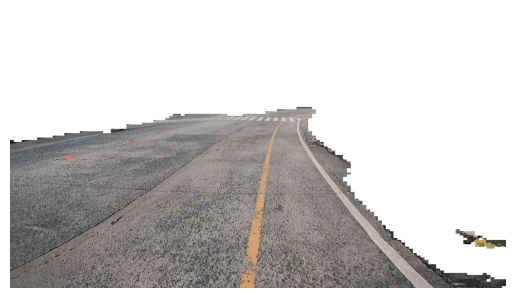

In [18]:
extracted_road = extract_road(original_image, image_segmentation, display_image=True)

In [19]:
def classify_road_condition(image):
    inputs = classification_processor(images=image, return_tensors="pt")
    outputs = classification_model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions).item()
    road_condition = "good" if predicted_class == 1 else "bad"
    return road_condition

In [20]:
good_road = Image.open('good_road.jpg').convert("RGB")
# classify_road_condition(good_road)
# classify_road_condition(extracted_road)
classify_road_condition(extracted_road)

'bad'

# Step 6: Object Detection

In [21]:
def detect_traffic_objects(image):
    inputs = detection_processor(images=image, return_tensors="pt")

    outputs = detection_model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])  # Target size in (height, width) format
    results = detection_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    detected_objects = []

    if 'scores' in results and 'labels' in results and 'boxes' in results:
        for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
            # Use the model's label map to get the class name from the label ID
            class_name = detection_model.config.id2label[label.item()]
            score_value = score.item()
            detected_objects.append({"label": class_name, "score": score_value, "box": box.tolist()})
    else:
        print("Expected keys ('scores', 'labels', 'boxes') not found in the results.")

    return list(set([c['label'] for c in detected_objects]))

def detect_general_objects(image):
    inputs = general_detection_processor(images=image, return_tensors="pt")

    outputs = general_detection_model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])  # Target size in (height, width) format
    results = detection_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    detected_objects = []

    if 'scores' in results and 'labels' in results and 'boxes' in results:
        for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
            # Use the model's label map to get the class name from the label ID
            class_name = general_detection_model.config.id2label[label.item()]
            score_value = score.item()
            detected_objects.append({"label": class_name, "score": score_value, "box": box.tolist()})
    else:
        print("Expected keys ('scores', 'labels', 'boxes') not found in the results.")

    return list(set([c['label'] for c in detected_objects]))

In [22]:
detect_traffic_objects(original_image)

['motorcycles']

In [23]:
detect_general_objects(original_image)

['car', 'person', 'motorcycle']

# Putting it all together (Pipeline)

In [34]:
def process_image(image_path, print_values=True, class_ids=[1], counter=-1):
    
    # Determine if the image is usable
    is_road, scene_label = is_road_image(image_path, places_model, categories)
    
    if is_road:
        # Open image
        image = Image.open(image_path).convert("RGB")
        
        # Segment image
        image_segmentation = segment_image(image_path, segmentation_processor, segmentation_model)
        
        # Determine categories
        categories_present = np.unique(image_segmentation).tolist()
        category_labels_present = [sidewalk_semantic_categories[c] for c in categories_present]

        # Metrics
        # obstruction_density = calculate_obstruction_density(image_segmentation)
        # additional_metrics = calculate_metrics(image_segmentation)
        category_contributions = get_category_contribution(image_segmentation)

        # Road quality
        extracted_road = extract_road(image, image_segmentation, class_ids=class_ids)
        road_condition = classify_road_condition(extracted_road)

        # Object detection
        traffic_objects = detect_traffic_objects(image)
        general_objects = detect_general_objects(image)
        
        if print_values:
            
            plt.imshow(image)
            plt.axis('off')
            plt.title('Test image')
            plt.show()
            
            visualize_segmentation(image_segmentation)
            print(f"""Category labels present: {category_labels_present}\n\n
Scene label: {scene_label}\n\n
Road condition: {road_condition}\n\n
Detected traffic objects: {traffic_objects}\n\n
Detected general objects: {general_objects}""")
            print('\n\nCategory contributions:\n')
            for k,v in category_contributions.items():
                if v != 0:
                    print(f"{k}: {round(v,4)}")

        
                    
        # Output
        output = {
            'scene_label' : scene_label,
            'elements_present' : category_labels_present,
            'road_condition' : road_condition,
            'traffic_objects' : traffic_objects,
            'general_objects' : general_objects
            # 'obstruction_density' : obstruction_density
        # }.update(additional_metrics)
        }
        
        output.update(category_contributions)
        
        if counter > -1:
            print(f'({counter}) Image has been successfully processed.')
        else:
            print('\n-----\nImage has been successfully processed.')
        return output        
    else:
        if counter > -1:
            print(f'({counter}) Image is not usable.')
        else:
            print('Image is not usable.')
        return None

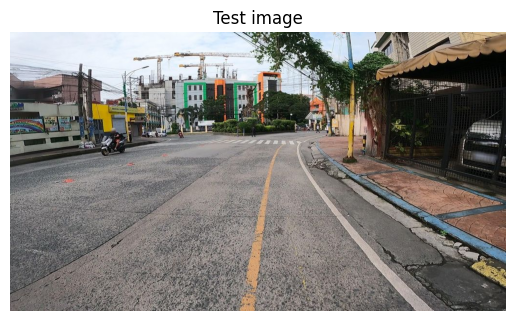

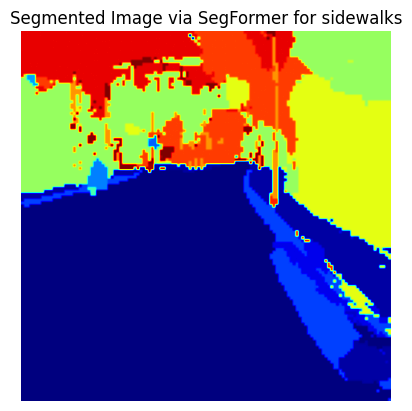

Category labels present: ['flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane', 'flat-parkingdriveway', 'flat-curb', 'human-person', 'human-rider', 'vehicle-car', 'vehicle-bicycle', 'construction-building', 'construction-wall', 'construction-fenceguardrail', 'object-pole', 'object-trafficsign', 'nature-vegetation', 'nature-terrain', 'sky', 'void-ground', 'void-dynamic', 'void-static']


Scene label: street


Road condition: bad


Detected traffic objects: ['motorcycles']


Detected general objects: ['car', 'person', 'motorcycle']


Category contributions:

flat-road: 0.4439
flat-sidewalk: 0.0594
flat-crosswalk: 0.0007
flat-cyclinglane: 0.0142
flat-parkingdriveway: 0.0001
flat-curb: 0.0475
human-person: 0.0007
human-rider: 0.0036
vehicle-car: 0.0009
vehicle-bicycle: 0.0004
construction-building: 0.1534
construction-wall: 0.0004
construction-fenceguardrail: 0.1099
object-pole: 0.0123
object-trafficsign: 0.0001
nature-vegetation: 0.0648
nature-terrain: 0.0012
sky: 0.0758
voi

NameError: name 'detected_objects' is not defined

In [25]:
image_path = "downloaded_images/6662508673859174_14.578278437308_121.03496566218.jpg"
output = process_image(image_path)

In [ ]:
image_path = "downloaded_images/2922512717961772_14.578411111111_121.03526944444.jpg"
output = process_image(image_path)

In [ ]:
image_path = "pedestrian-test.jpg"
output = process_image(image_path)

Based on the last processed image, both object detection models cannot detect traffic signs. My suggestion is to use the `object-trafficsign` category from the image segmentation. For example, if the contribution of this category exceeds a set threshold, say `0.002`, then we can consider the image to have a traffic sign. Currently, I cannot utilize a huggingface 

---

# Batch processing images

In [130]:
df = pd.read_csv('mandaluyong_bounding_box_a_data_2024.csv')
df = df[10:15]
image_folder = 'downloaded_images_2024'

i = 1
# image_data = []

for index, row in df.iterrows():
    image_id = row['image_id']
    lat = row['latitude']
    lon = row['longitude']
    image_name = f"{image_id}_{lat}_{lon}.jpg"

    try:
        process_output = process_image(f'{image_folder}/{image_name}', print_values=False, counter=i)        
        i += 1
        
        if process_output is None:
            continue
    
        else:
            final_output = {
                'image_id' : image_id,
                'latitude' : lat,
                'longitude' : lon,
            }
            final_output.update(process_output)
            # image_data.append(final_output)
            image_df = pd.concat([image_df, pd.DataFrame([final_output])], ignore_index=True)
    except:
        continue

(1) Image is not usable.
(2) Image has been successfully processed.
(3) Image is not usable.
(4) Image has been successfully processed.
(5) Image is not usable.


In [132]:
image_df.shape

(5, 43)

It finally works!

In [133]:
df = pd.read_csv('mandaluyong_bounding_box_a_data_2024.csv')
df = df[15:]
image_folder = 'downloaded_images_2024'

i = 1

for index, row in df.iterrows():
    image_id = row['image_id']
    lat = row['latitude']
    lon = row['longitude']
    image_name = f"{image_id}_{lat}_{lon}.jpg"

    try:
        process_output = process_image(f'{image_folder}/{image_name}', print_values=False, counter=i)        
        i += 1
        
        if process_output is None:
            continue
    
        else:
            final_output = {
                'image_id' : image_id,
                'latitude' : lat,
                'longitude' : lon,
            }
            final_output.update(process_output)
            # image_data.append(final_output)
            image_df = pd.concat([image_df, pd.DataFrame([final_output])], ignore_index=True)
    except:
        continue

(1) Image is not usable.
(2) Image is not usable.
(3) Image is not usable.
(4) Image is not usable.
(5) Image is not usable.
(6) Image is not usable.
(7) Image is not usable.
(8) Image is not usable.
(9) Image is not usable.
(10) Image is not usable.
(11) Image is not usable.
(12) Image is not usable.
(13) Image is not usable.
(14) Image is not usable.
(15) Image is not usable.
(16) Image is not usable.
(17) Image is not usable.
(18) Image is not usable.
(19) Image is not usable.
(20) Image is not usable.
(21) Image is not usable.
(22) Image is not usable.
(23) Image is not usable.
(24) Image is not usable.
(25) Image is not usable.
(26) Image is not usable.
(27) Image is not usable.
(28) Image has been successfully processed.
(29) Image is not usable.
(30) Image is not usable.
(31) Image is not usable.
(32) Image is not usable.
(33) Image is not usable.
(34) Image is not usable.
(35) Image is not usable.
(36) Image is not usable.
(37) Image is not usable.
(38) Image is not usable.
(39

In [136]:
image_df.to_csv('batch1_image_classification.csv',index=False)

I forgot to update a variable's name in the pipeline so all `traffic_objects` have the same value. The code below fixes this.

In [50]:
## Fix batch 1:
image_folder = 'downloaded_images_2024'

df = pd.read_csv('batch1_image_classification.csv')
for index, row in df.iterrows():
    image_id = row['image_id']
    lat = row['latitude']
    lon = row['longitude']
    image_name = f"{image_id}_{lat}_{lon}.jpg"

    image = Image.open(f"{image_folder}/{image_name}").convert("RGB")
    
    # Object detection
    traffic_objects = detect_traffic_objects(image)

    df.at[index,'traffic_objects'] = traffic_objects
    print(f"({index}) done")
    

(0) done
(1) done
(2) done
(3) done
(4) done
(5) done
(6) done
(7) done
(8) done
(9) done
(10) done
(11) done
(12) done
(13) done
(14) done
(15) done
(16) done
(17) done
(18) done
(19) done
(20) done
(21) done
(22) done
(23) done
(24) done
(25) done
(26) done
(27) done
(28) done
(29) done
(30) done
(31) done
(32) done
(33) done
(34) done
(35) done
(36) done
(37) done
(38) done
(39) done
(40) done
(41) done
(42) done
(43) done
(44) done
(45) done
(46) done
(47) done
(48) done
(49) done
(50) done
(51) done
(52) done
(53) done
(54) done
(55) done
(56) done
(57) done
(58) done
(59) done
(60) done
(61) done
(62) done
(63) done
(64) done
(65) done
(66) done
(67) done
(68) done
(69) done
(70) done
(71) done
(72) done
(73) done
(74) done
(75) done
(76) done
(77) done
(78) done
(79) done
(80) done
(81) done
(82) done
(83) done
(84) done
(85) done
(86) done
(87) done
(88) done
(89) done
(90) done
(91) done
(92) done
(93) done
(94) done
(95) done
(96) done
(97) done
(98) done
(99) done
(100) done

In [51]:
df.head()

,image_id,latitude,longitude,scene_label,elements_present,road_condition,traffic_objects,general_objects,unlabeled,flat-road,...,object-pole,object-trafficsign,object-trafficlight,nature-vegetation,nature-terrain,sky,void-ground,void-dynamic,void-static,void-unclear
0,1951363835294303,14.580650,121.050660,alley,"['flat-road', 'flat-sidewalk', 'flat-crosswalk...",bad,[vehicles],"['car', 'fire hydrant']",0.0,0.065430,...,0.007690,0.0,0.0,0.278076,0.000000,0.071655,0.000000,0.000000,0.013184,0.0
1,1402771570405814,14.576947,121.056274,residential_neighborhood,"['flat-road', 'flat-sidewalk', 'flat-cyclingla...",good,[vehicles],"['car', 'truck', 'person']",0.0,0.133606,...,0.002136,0.0,0.0,0.507874,0.003662,0.062866,0.000000,0.000000,0.008179,0.0
2,1459029184722052,14.572276,121.043395,residential_neighborhood,"['flat-road', 'flat-sidewalk', 'flat-crosswalk...",bad,[vehicles],"['car', 'truck', 'person']",0.0,0.055664,...,0.001099,0.0,0.0,0.368042,0.000000,0.199829,0.000061,0.000488,0.013000,0.0
3,3824551994486414,14.577642,121.042987,alley,"['flat-road', 'flat-sidewalk', 'flat-crosswalk...",bad,"[vehicles, motorcycles]","['car', 'clock', 'person', 'truck', 'motorcycle']",0.0,0.048340,...,0.003113,0.0,0.0,0.148254,0.000000,0.279297,0.000000,0.004578,0.003418,0.0
4,1386413215405023,14.573386,121.044994,street,"['flat-road', 'flat-sidewalk', 'flat-crosswalk...",bad,[vehicles],"['car', 'person', 'truck', 'bus', 'stop sign']",0.0,0.172485,...,0.031372,0.0,0.0,0.045349,0.000000,0.147522,0.004395,0.002136,0.050293,0.0


In [52]:
df.to_csv('UPDATED_batch1_image_classification.csv', index=False)

In [53]:
df = pd.read_csv('batch2-df.csv')
df = df[:15]
image_folder = 'downloaded_images_2024'

i = 1
image_data = []

for index, row in df.iterrows():
    image_id = row['image_id']
    lat = row['latitude']
    lon = row['longitude']
    image_name = f"{image_id}_{lat}_{lon}.jpg"

    try:
        process_output = process_image(f'{image_folder}/{image_name}', print_values=False, counter=i)        
        i += 1
        
        if process_output is None:
            continue
    
        else:
            final_output = {
                'image_id' : image_id,
                'latitude' : lat,
                'longitude' : lon,
            }
            final_output.update(process_output)
            image_data.append(final_output)
            
    except Exception as e:
        print(f"Error encountered: {e}. Continuing with the next item.")

(1) Image is not usable.
(2) Image is not usable.
(3) Image is not usable.
(4) Image is not usable.
(5) Image is not usable.
(6) Image is not usable.
(7) Image is not usable.
(8) Image is not usable.
(9) Image is not usable.
(10) Image has been successfully processed.
(11) Image is not usable.
(12) Image is not usable.
(13) Image is not usable.
(14) Image has been successfully processed.
(15) Image has been successfully processed.


In [54]:
image_df2 = pd.DataFrame(image_data)

In [55]:
image_df2

,image_id,latitude,longitude,scene_label,elements_present,road_condition,traffic_objects,general_objects,unlabeled,flat-road,...,object-pole,object-trafficsign,object-trafficlight,nature-vegetation,nature-terrain,sky,void-ground,void-dynamic,void-static,void-unclear
0,3563212963897089,14.571867,121.047222,street,"[flat-road, flat-sidewalk, flat-crosswalk, fla...",bad,"[vehicles, crosswalks]","[car, traffic light, motorcycle, person]",0.0,0.206604,...,0.009583,0.000366,0.0,0.100647,0.000000,0.054626,0.000000,0.0,0.032654,0.0
1,400155059278007,14.584167,121.055761,highway,"[flat-road, flat-sidewalk, flat-crosswalk, fla...",bad,[vehicles],"[car, person, fire hydrant]",0.0,0.050537,...,0.000427,0.000305,0.0,0.028625,0.000061,0.144165,0.000000,0.0,0.098083,0.0
2,1466595977573571,14.573783,121.048547,alley,"[flat-road, flat-sidewalk, flat-crosswalk, fla...",bad,[vehicles],"[car, person]",0.0,0.066284,...,0.001831,0.000000,0.0,0.019165,0.000000,0.024292,0.000122,0.0,0.108276,0.0


In [56]:
df = pd.read_csv('batch2-df.csv')
df = df[15:]
image_folder = 'downloaded_images_2024'

i = 1

for index, row in df.iterrows():
    image_id = row['image_id']
    lat = row['latitude']
    lon = row['longitude']
    image_name = f"{image_id}_{lat}_{lon}.jpg"

    try:
        process_output = process_image(f'{image_folder}/{image_name}', print_values=False, counter=i)        
        i += 1
        
        if process_output is None:
            continue
    
        else:
            final_output = {
                'image_id' : image_id,
                'latitude' : lat,
                'longitude' : lon,
            }
            final_output.update(process_output)
            # image_data.append(final_output)
            image_df2 = pd.concat([image_df2, pd.DataFrame([final_output])], ignore_index=True)
            
    except Exception as e:
        print(f"Error encountered: {e}. Continuing with the next item.")

(1) Image is not usable.
(2) Image is not usable.
(3) Image is not usable.
(4) Image is not usable.
(5) Image is not usable.
(6) Image has been successfully processed.
(7) Image has been successfully processed.
(8) Image is not usable.
(9) Image has been successfully processed.
(10) Image is not usable.
(11) Image has been successfully processed.
(12) Image is not usable.
(13) Image has been successfully processed.
(14) Image has been successfully processed.
(15) Image has been successfully processed.
(16) Image is not usable.
(17) Image is not usable.
(18) Image is not usable.
(19) Image is not usable.
(20) Image has been successfully processed.
(21) Image has been successfully processed.
(22) Image is not usable.
(23) Image is not usable.
(24) Image has been successfully processed.
(25) Image is not usable.
(26) Image is not usable.
(27) Image is not usable.
(28) Image is not usable.
(29) Image has been successfully processed.
(30) Image is not usable.
(31) Image has been successfull

In [57]:
image_df2.shape

(2081, 43)

In [58]:
image_df1 = pd.read_csv('UPDATED_batch1_image_classification.csv')

In [59]:
image_df1.shape

(672, 43)

In [60]:
combined_df = pd.concat([image_df1, image_df2], axis=0, ignore_index=True)

In [61]:
combined_df.shape

(2753, 43)

In [62]:
combined_df.to_csv('final_image_processing.csv', index=False)